In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time
from regions import CircleSkyRegion

import logging

log = logging.getLogger(__name__)

## GRB190114C

From paper of MAGIC collaboration (Nature, 575, 455, 2019)

Redshift: z=0.4245

Power law spectrum, with Gamma=5.4, F0=4.1e-10 ph/Tev/cm2/s at E0=0.475 TeV in the 0.3-1 TeV band.

Power law light curve, with delta=-1.6 

T0=14 January 2019, 20:57:03 UTC (t_ref in this notebook)

MAGIC observations started T+57s and lasted T0+15912 s


In [54]:
# Define the model

from gammapy.modeling.models import TemporalModel
from gammapy.modeling import Parameter
class PowerlawDecayTemporalModel(TemporalModel):
    """Temporal model with a power law decay.
        ..math::
                np.power(( (time - t_ref) / t0 ), index)
    Parameters
    ----------
    t0 : `~astropy.units.Quantity`
        Decay time scale
    t_ref: `~astropy.units.Quantity`
        The reference time 
    index: `~astropy.units.Quantity`
        Power index 
    """

    tag = "PowerlawDecayTemporalModel"

    t0 = Parameter("t0", 1.*u.s, frozen=True)

    _t_ref_default = Time("2000-01-01")
    t_ref = Parameter("t_ref", (_t_ref_default.mjd*u.d).to(u.s), frozen=True)
    
    t_index = Parameter("t_index", -2.0)

    @staticmethod
    def evaluate(time, t0, t_ref, t_index):
        """Evaluate at given times"""
        return np.power(( (time - t_ref) / t0 ), t_index)

    def integral(self, t_min, t_max):
        """Evaluate the integrated flux within the given time intervals
        Parameters
        ----------
        t_min: `~astropy.time.Time`
            Start times of observation
        t_max: `~astropy.time.Time`
            Stop times of observation
        Returns
        -------
        norm : float
            Integrated flux norm on the given time intervals
        """
        pars = self.parameters
        t0 = pars["t0"].quantity
        t_index = pars["t_index"].quantity
        #t_ref = Time(pars["t_ref"].quantity, format="mjd")
        t_ref = pars["t_ref"].quantity
        dec1 = t_index+1.0
        value = self.evaluate(t_max, t0, t_ref, dec1) - self.evaluate(t_min, t0, t_ref, dec1)
        return (t0/dec1) * value / self.time_sum(t_min, t_max)

Temporal model at t = T0 + 80 s: 0.0009016874411920081
Temporal model at t = T0' + 10^3 s: 1.5848931924611124e-05


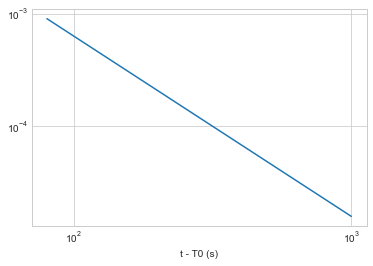

In [55]:
# Plot the model
plt.style.use('seaborn-whitegrid')

gti_t0 = Time("2019-01-14 20:57:03")
temporal_model = PowerlawDecayTemporalModel(t0=1 * u.s, t_ref=(gti_t0.mjd*u.d).to(u.s), t_index=-1.6)

pars = temporal_model.parameters

t0 = pars['t0'].quantity
t_ref = pars['t_ref'].quantity
t_index= pars['t_index'].quantity

time = []
values = []

for i in range(80, 1000):
    t = t_ref + i * u.s
    time.append(t)
    v = temporal_model.evaluate(t, t0, t_ref, t_index)
    values.append(v)
    
x = [(t-t_ref).value for t in time]
y = [v.value for v in values]

plt.loglog(x, y)
plt.xlabel('t - T0 (s)')

t_min = t_ref + 80 * u.s
value1 = temporal_model.evaluate(t_min, t0, t_ref, t_index)
print("Temporal model at t = T0 + 80 s: {}".format(value1))
t_max = t_ref + 1000 * u.s
value2 = temporal_model.evaluate(t_max, t0, t_ref, t_index)
print("Temporal model at t = T0' + 10^3 s: {}".format(value2))

In [58]:
temporal_model.integral(t_min, t_max)

<Quantity 0.00010197>